# Phase 4 Project Notebook
- Author: Jonathan Holt
- Data Science Flex

## Business Problem
- What are the top 5 best zip codes for us to invest in?

## Questions to Answer

1. What is the average (mean) home price for zip codes?
    a. also by: State, Metro Region, etc.
2. Which zip codes performed above expectations?
3. Do the top performing zip codes have any identifiers?


## What Models & Metrics I plan on using

## Helper Functions
- Functions provided by Flatiron

In [1]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [2]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passed in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## Loading Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed

In [4]:
df = pd.read_csv("zillow_data.csv")

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [100]:
df.iloc[0, 7:].mean()

743978.8679245283

In [125]:
data_df = df.iloc[:, 7:]
data_df.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [126]:
zip_test = data_df.iloc[0]

In [127]:
zip_test

1996-04     334200.0
1996-05     335400.0
1996-06     336500.0
1996-07     337600.0
1996-08     338500.0
1996-09     339500.0
1996-10     340400.0
1996-11     341300.0
1996-12     342600.0
1997-01     344400.0
1997-02     345700.0
1997-03     346700.0
1997-04     347800.0
1997-05     349000.0
1997-06     350400.0
1997-07     352000.0
1997-08     353900.0
1997-09     356200.0
1997-10     358800.0
1997-11     361800.0
1997-12     365700.0
1998-01     370200.0
1998-02     374700.0
1998-03     378900.0
1998-04     383500.0
1998-05     388300.0
1998-06     393300.0
1998-07     398500.0
1998-08     403800.0
1998-09     409100.0
1998-10     414600.0
1998-11     420100.0
1998-12     426200.0
1999-01     432600.0
1999-02     438600.0
1999-03     444200.0
1999-04     450000.0
1999-05     455900.0
1999-06     462100.0
1999-07     468500.0
1999-08     475300.0
1999-09     482500.0
1999-10     490200.0
1999-11     498200.0
1999-12     507200.0
2000-01     516800.0
2000-02     526300.0
2000-03     5

In [128]:
zip_test = zip_test.reset_index()

In [130]:
zip_test.head()

,index,0
0,1996-04,334200.0
1,1996-05,335400.0
2,1996-06,336500.0
3,1996-07,337600.0
4,1996-08,338500.0


In [131]:
zip_test.rename(columns={"index": "date"}, inplace=True)

In [134]:
zip_test['date'] = pd.to_datetime(zip_test['date'])

In [135]:
zip_test.head()

,date,0
0,1996-04-01,334200.0
1,1996-05-01,335400.0
2,1996-06-01,336500.0
3,1996-07-01,337600.0
4,1996-08-01,338500.0


In [139]:
zip_test = zip_test.set_index('date')

In [143]:
zip_test.resample("Y").mean()

,0
date,
1996-12-31,3.384444e+05
1997-12-31,3.527000e+05
1998-12-31,3.967667e+05
1999-12-31,4.671083e+05
2000-12-31,5.658833e+05
2001-12-31,6.539833e+05
2002-12-31,7.117583e+05
2003-12-31,7.443750e+05
2004-12-31,7.840667e+05


In [140]:
zip_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


In [124]:
zip_test.drop([0])

,time,0
1,RegionName,60657
2,City,Chicago
3,State,IL
4,Metro,Chicago
5,CountyName,Cook
6,SizeRank,1
7,1996-04,334200
8,1996-05,335400
9,1996-06,336500
10,1996-07,337600


In [97]:
df.iloc[:, 7:].mean()

1996-04    118299.123063
1996-05    118419.044139
1996-06    118537.423268
1996-07    118653.069278
1996-08    118780.254312
1996-09    118927.528500
1996-10    119120.520316
1996-11    119345.352236
1996-12    119685.084771
1997-01    120121.265712
1997-02    120544.241450
1997-03    120896.623794
1997-04    121268.174510
1997-05    121655.897398
1997-06    122053.105817
1997-07    122456.339057
1997-08    122879.926927
1997-09    123327.402265
1997-10    123823.105590
1997-11    124353.737669
1997-12    125002.601388
1998-01    125736.669833
1998-02    126450.778111
1998-03    127086.257032
1998-04    127736.362972
1998-05    128385.014978
1998-06    129032.702564
1998-07    129676.357127
1998-08    130324.519617
1998-09    130982.618543
1998-10    131678.088697
1998-11    132399.342442
1998-12    133224.702272
1999-01    134133.593921
1999-02    135020.881128
1999-03    135841.586907
1999-04    136683.794842
1999-05    137532.147293
1999-06    138391.809746
1999-07    139265.156718


In [6]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


## Checking for Null Values

In [8]:
df.isnull().sum().head(10)

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
dtype: int64

### Analysis

There are many Null Values. 
- For categorical data, 7% of Metro are null (1043 of 14,723).
- Dates from 1996 - mid 2003, also have 7% null values.
- Then it starts to get better. 6% null and decreasing.

What is my decision on null values?
- keep?
- delete?
- change (mean)?

# Finding Average Values

## Dealing with Nulls

In [9]:
df.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


## Grouping by State

In [10]:
#recent_data.groupby('genres_list')['production_budget'].describe().sort_values('mean', ascending=False)
state_df = df.groupby('State')

In [11]:
state_df = state_df.mean()
state_df.head()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
State,,,,,,,,,,,,,,,,,,,,,
AK,111822.214286,99616.785714,6321.035714,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,...,317921.428571,318610.714286,319382.142857,320185.714286,321378.571429,322657.142857,323775.000000,324167.857143,323692.857143,323046.428571
AL,73606.803279,35779.169399,7580.245902,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,...,149255.191257,149675.956284,150125.136612,150537.704918,150969.945355,151629.508197,152402.732240,153625.683060,155504.371585,157033.879781
AR,92528.914286,72470.733333,7381.476190,68868.041237,69015.463918,69140.206186,69262.886598,69378.350515,69507.216495,69674.226804,...,131952.380952,132379.047619,132778.095238,132973.333333,133020.000000,133188.571429,133522.857143,134456.190476,136192.380952,137620.000000
AZ,127652.643478,85506.465217,5017.873913,116202.790698,116562.790698,116934.883721,117315.348837,117719.534884,118150.232558,118626.511628,...,257896.086957,259598.260870,261243.043478,262884.347826,264369.130435,265908.260870,267327.826087,268714.782609,270488.695652,271952.173913
CA,99003.562092,93308.559641,5070.638889,200220.959596,200124.831650,200035.942761,199965.572391,199958.754209,200037.626263,200277.020202,...,692367.156863,697869.607843,704045.669935,710515.114379,716760.866013,723263.480392,729496.405229,735525.980392,742146.323529,746329.084967


In [12]:
#dropping categorical columns
state_df.drop(columns=['RegionID', 'RegionName', 'SizeRank'], axis=1, inplace=True)

In [13]:
#new_header = df.iloc[0] #grab the first row for the header
#df = df[1:] #take the data less the header row
#df.columns = new_header #set the header row as the df header
    
#df.rename(columns=df.iloc[0])    

In [14]:
state_df.iloc[:, 0]

State
AK    128382.142857
AL     86795.569620
AR     68868.041237
AZ    116202.790698
CA    200220.959596
CO    142561.943320
CT    157189.516129
DC    189216.666667
DE    125784.615385
FL    104529.019608
GA     95783.161512
HI    211811.764706
IA     78396.621622
ID     91951.578947
IL    127624.665392
IN     87843.112245
KS     77842.261905
KY     82155.000000
LA     65484.827586
MA    159684.541063
MD    146417.891374
ME     98218.181818
MI     92833.995585
MN     90961.918605
MO     91146.468401
MS     86397.014925
MT    157838.461538
NC     91146.019900
ND              NaN
NE     89468.571429
NH    107132.820513
NJ    175215.936255
NM    137096.226415
NV    153680.681818
NY    129927.512690
OH     88665.973535
OK     53432.380952
OR    124325.714286
PA     89103.011292
RI    125286.440678
SC     82504.687500
SD     54320.000000
TN     66087.468672
TX    109384.639831
UT    159645.689655
VA    122071.236559
VT     82825.000000
WA    140589.285714
WI    115151.376147
WV     66461.6

In [15]:
new_header = state_df.iloc[0]

# Using Virginia as an example to figure out how to do this

In [69]:
new_df = va_df

In [70]:
state_df.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
State,,,,,,,,,,,,,,,,,,,,,
AK,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,131085.714286,131557.142857,132107.142857,...,317921.428571,318610.714286,319382.142857,320185.714286,321378.571429,322657.142857,323775.000000,324167.857143,323692.857143,323046.428571
AL,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,89327.848101,89800.632911,90325.949367,...,149255.191257,149675.956284,150125.136612,150537.704918,150969.945355,151629.508197,152402.732240,153625.683060,155504.371585,157033.879781
AR,68868.041237,69015.463918,69140.206186,69262.886598,69378.350515,69507.216495,69674.226804,69885.567010,70167.010309,70535.051546,...,131952.380952,132379.047619,132778.095238,132973.333333,133020.000000,133188.571429,133522.857143,134456.190476,136192.380952,137620.000000
AZ,116202.790698,116562.790698,116934.883721,117315.348837,117719.534884,118150.232558,118626.511628,119141.395349,119773.488372,120472.093023,...,257896.086957,259598.260870,261243.043478,262884.347826,264369.130435,265908.260870,267327.826087,268714.782609,270488.695652,271952.173913
CA,200220.959596,200124.831650,200035.942761,199965.572391,199958.754209,200037.626263,200277.020202,200643.013468,201309.680135,202229.124579,...,692367.156863,697869.607843,704045.669935,710515.114379,716760.866013,723263.480392,729496.405229,735525.980392,742146.323529,746329.084967


In [ ]:
state_df.map()
    

In [16]:
va_df = state_df.iloc[45]
va_df.head()

1996-04    122071.236559
1996-05    122136.827957
1996-06    122201.075269
1996-07    122267.204301
1996-08    122352.419355
Name: VA, dtype: float64

In [17]:
va_df = va_df.reset_index()
va_df.head()

,index,VA
0,1996-04,122071.236559
1,1996-05,122136.827957
2,1996-06,122201.075269
3,1996-07,122267.204301
4,1996-08,122352.419355


In [18]:
va_df.rename(columns={"index": "Date", "VA": "home_sales"}, inplace=True)

In [19]:
va_df.head()

,Date,home_sales
0,1996-04,122071.236559
1,1996-05,122136.827957
2,1996-06,122201.075269
3,1996-07,122267.204301
4,1996-08,122352.419355


In [20]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        265 non-null    object 
 1   home_sales  265 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.3+ KB


In [21]:
va_df['Date'] = pd.to_datetime(va_df['Date'])

In [22]:
va_df['home_sales'] = va_df['home_sales'].apply(lambda x: float("{:.2f}".format(x)))

In [23]:
va_df.head()

,Date,home_sales
0,1996-04-01,122071.24
1,1996-05-01,122136.83
2,1996-06-01,122201.08
3,1996-07-01,122267.20
4,1996-08-01,122352.42


In [24]:
va_df = va_df.set_index('Date')

In [25]:
va_df.head(10)

,home_sales
Date,
1996-04-01,122071.24
1996-05-01,122136.83
1996-06-01,122201.08
1996-07-01,122267.20
1996-08-01,122352.42
1996-09-01,122473.92
1996-10-01,122653.49
1996-11-01,122871.51
1996-12-01,123210.48


In [26]:
va_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   home_sales  265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


In [27]:
import matplotlib.ticker as mtick

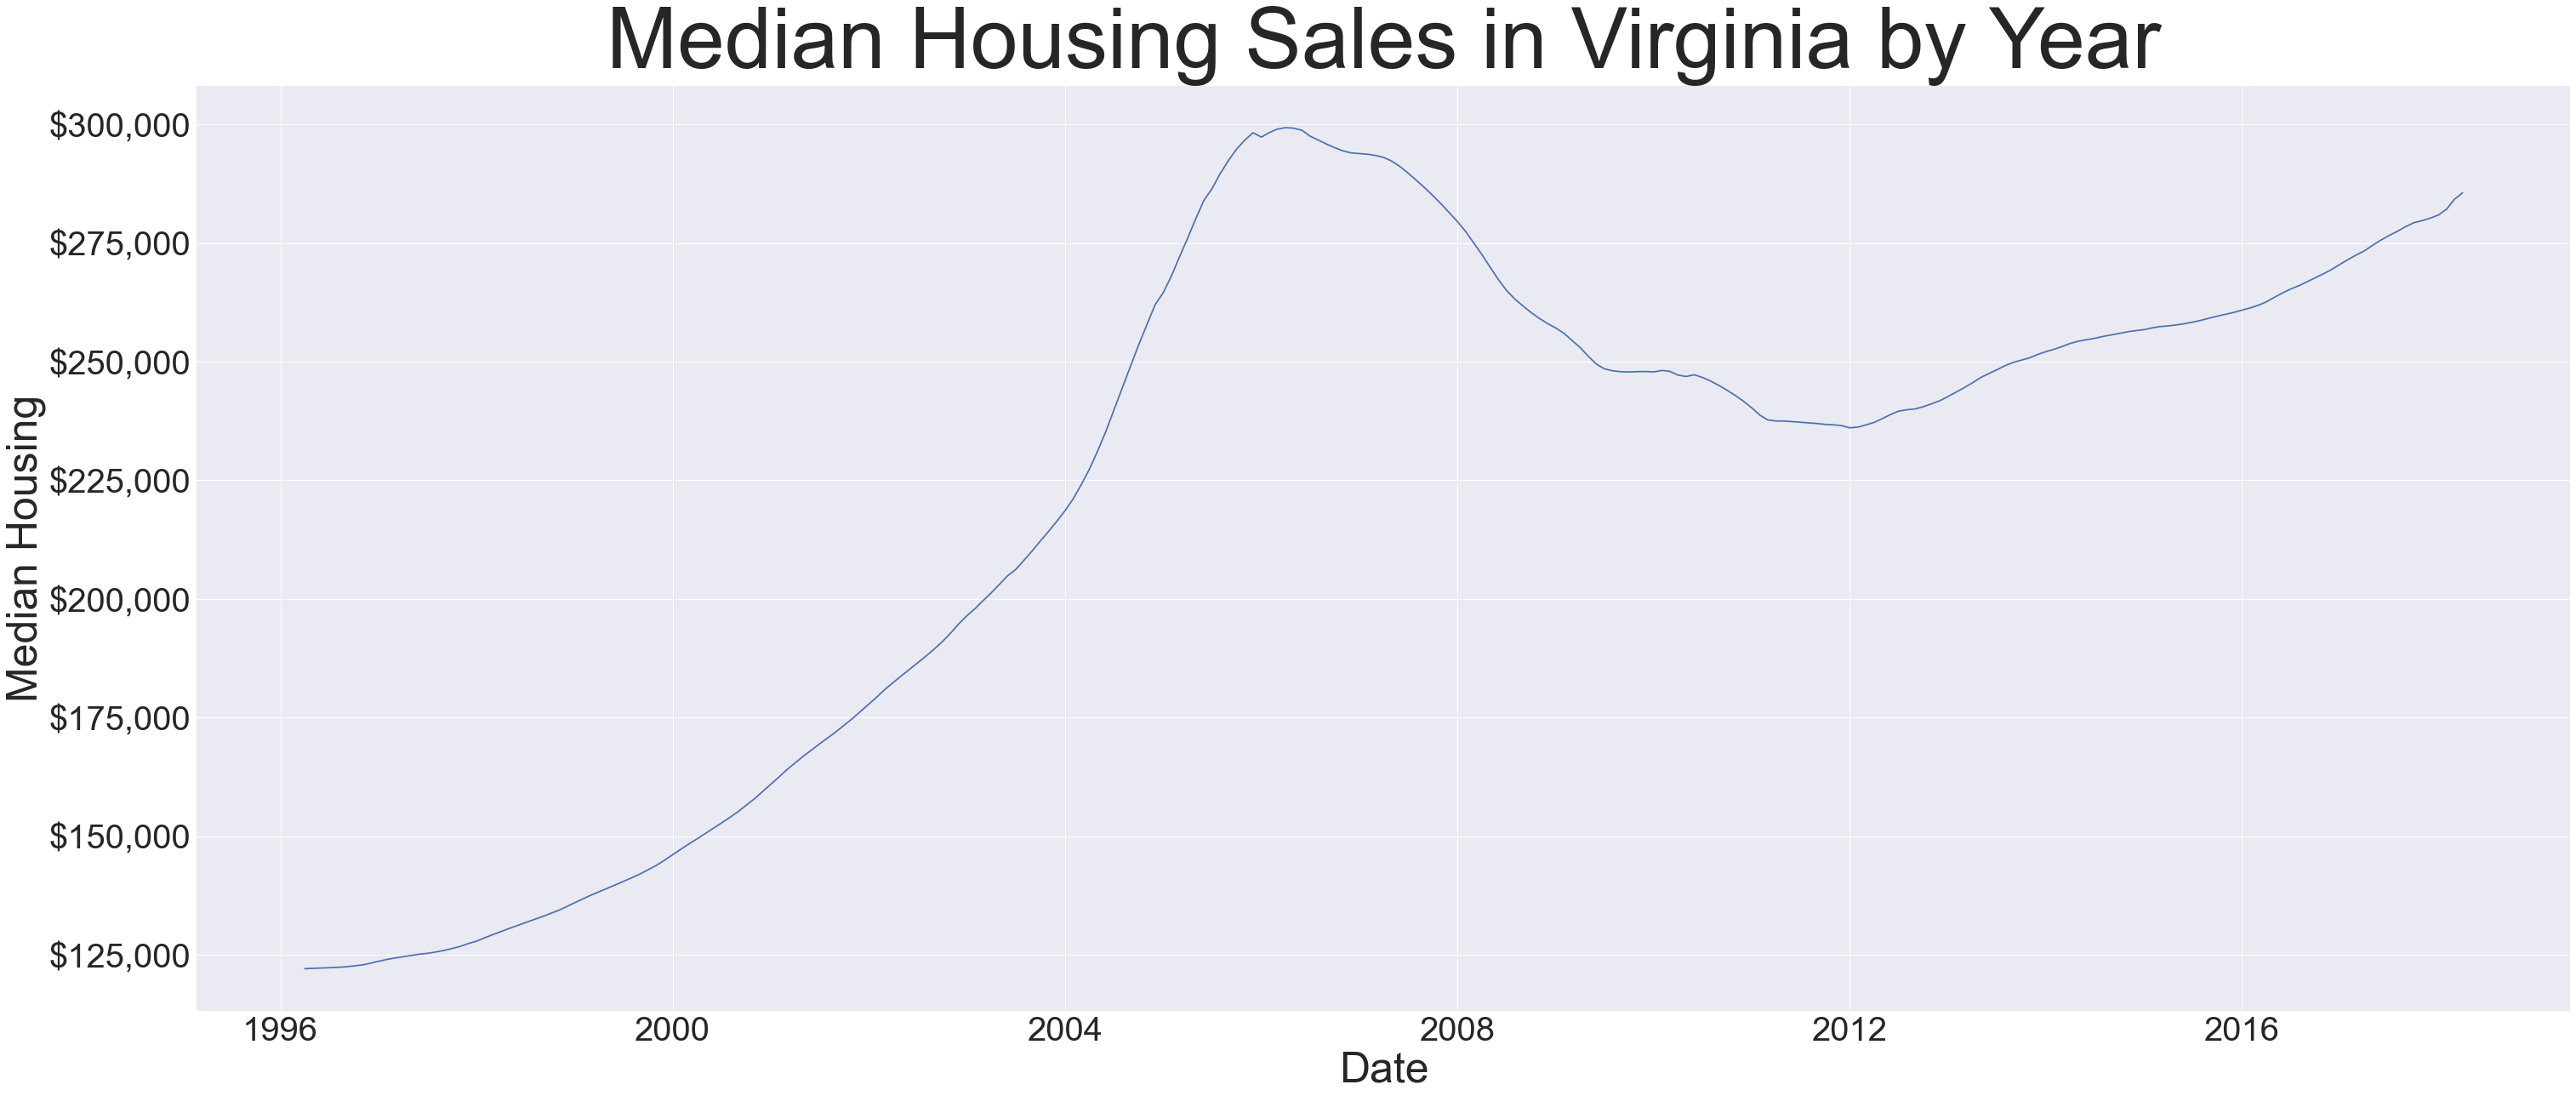

In [28]:
fig, ax = plt.subplots(figsize=(50, 20))
p = sns.lineplot(data=va_df, x='Date', y='home_sales');
p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales in Virginia by Year", fontsize = 100)
plt.figsize=(50,25)

plt.show();

In [29]:
va_df.head(2)

,home_sales
Date,
1996-04-01,122071.24
1996-05-01,122136.83


In [30]:
va_df.resample('Y').sum()

,home_sales
Date,
1996-12-31,1102238.17
1997-12-31,1503780.55
1998-12-31,1577539.50
1999-12-31,1682607.20
2000-12-31,1829035.99
2001-12-31,2024666.94
2002-12-31,2231875.20
2003-12-31,2470413.59
2004-12-31,2864042.71


# Melting State_df and attempting to get all the states

In [63]:
state_df.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
State,,,,,,,,,,,,,,,,,,,,,
AK,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,131085.714286,131557.142857,132107.142857,...,317921.428571,318610.714286,319382.142857,320185.714286,321378.571429,322657.142857,323775.000000,324167.857143,323692.857143,323046.428571
AL,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,89327.848101,89800.632911,90325.949367,...,149255.191257,149675.956284,150125.136612,150537.704918,150969.945355,151629.508197,152402.732240,153625.683060,155504.371585,157033.879781
AR,68868.041237,69015.463918,69140.206186,69262.886598,69378.350515,69507.216495,69674.226804,69885.567010,70167.010309,70535.051546,...,131952.380952,132379.047619,132778.095238,132973.333333,133020.000000,133188.571429,133522.857143,134456.190476,136192.380952,137620.000000
AZ,116202.790698,116562.790698,116934.883721,117315.348837,117719.534884,118150.232558,118626.511628,119141.395349,119773.488372,120472.093023,...,257896.086957,259598.260870,261243.043478,262884.347826,264369.130435,265908.260870,267327.826087,268714.782609,270488.695652,271952.173913
CA,200220.959596,200124.831650,200035.942761,199965.572391,199958.754209,200037.626263,200277.020202,200643.013468,201309.680135,202229.124579,...,692367.156863,697869.607843,704045.669935,710515.114379,716760.866013,723263.480392,729496.405229,735525.980392,742146.323529,746329.084967


In [ ]:
 #melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'],
 #   var_name='time')

In [ ]:
state_df

In [64]:
state_melt_df = pd.melt(state_df)

In [65]:
state_melt_df

,variable,value
0,1996-04,128382.142857
1,1996-04,86795.569620
2,1996-04,68868.041237
3,1996-04,116202.790698
4,1996-04,200220.959596
...,...,...
13510,2018-04,213150.000000
13511,2018-04,408570.381232
13512,2018-04,199015.361446
13513,2018-04,125476.388889


KeyError: "The following 'id_vars' are not present in the DataFrame: ['City', 'CountyName', 'Metro', 'RegionID', 'RegionName', 'SizeRank', 'State']"

In [54]:
flipped_df.head()

State,index,AK,AL,AR,AZ,CA,CO,CT,DC,DE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,1996-04,128382.142857,86795.569620,68868.041237,116202.790698,200220.959596,142561.943320,157189.516129,189216.666667,125784.615385,...,54320.0,66087.468672,109384.639831,159645.689655,122071.236559,82825.00,140589.285714,115151.376147,66461.666667,138712.500000
1,1996-05,128832.142857,87122.151899,69015.463918,116562.790698,200124.831650,142765.991903,157063.709677,188611.111111,126234.615385,...,54640.0,66340.852130,109406.885593,159523.275862,122136.827957,82556.25,140838.988095,115099.388379,66575.000000,138762.500000
2,1996-06,129253.571429,87460.759494,69140.206186,116934.883721,200035.942761,142985.425101,156926.612903,188011.111111,126665.384615,...,54960.0,66594.987469,109451.377119,159406.896552,122201.075269,82306.25,141101.488095,115032.110092,66708.333333,138741.666667
3,1996-07,129639.285714,87798.734177,69262.886598,117315.348837,199965.572391,143204.453441,156778.225806,187438.888889,127026.923077,...,55290.0,66843.107769,109521.504237,159313.793103,122267.204301,82037.50,141378.571429,114940.672783,66848.333333,138641.666667
4,1996-08,130028.571429,88156.962025,69378.350515,117719.534884,199958.754209,143461.943320,156640.322581,186900.000000,127346.153846,...,55660.0,67081.704261,109613.983051,159254.310345,122352.419355,81781.25,141686.011905,114840.978593,67016.666667,138533.333333


In [55]:
flipped_df.rename(columns={"index": "Date"}, inplace=True)

In [56]:
flipped_df.head()

State,Date,AK,AL,AR,AZ,CA,CO,CT,DC,DE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,1996-04,128382.142857,86795.569620,68868.041237,116202.790698,200220.959596,142561.943320,157189.516129,189216.666667,125784.615385,...,54320.0,66087.468672,109384.639831,159645.689655,122071.236559,82825.00,140589.285714,115151.376147,66461.666667,138712.500000
1,1996-05,128832.142857,87122.151899,69015.463918,116562.790698,200124.831650,142765.991903,157063.709677,188611.111111,126234.615385,...,54640.0,66340.852130,109406.885593,159523.275862,122136.827957,82556.25,140838.988095,115099.388379,66575.000000,138762.500000
2,1996-06,129253.571429,87460.759494,69140.206186,116934.883721,200035.942761,142985.425101,156926.612903,188011.111111,126665.384615,...,54960.0,66594.987469,109451.377119,159406.896552,122201.075269,82306.25,141101.488095,115032.110092,66708.333333,138741.666667
3,1996-07,129639.285714,87798.734177,69262.886598,117315.348837,199965.572391,143204.453441,156778.225806,187438.888889,127026.923077,...,55290.0,66843.107769,109521.504237,159313.793103,122267.204301,82037.50,141378.571429,114940.672783,66848.333333,138641.666667
4,1996-08,130028.571429,88156.962025,69378.350515,117719.534884,199958.754209,143461.943320,156640.322581,186900.000000,127346.153846,...,55660.0,67081.704261,109613.983051,159254.310345,122352.419355,81781.25,141686.011905,114840.978593,67016.666667,138533.333333


In [59]:
flipped_df = flipped_df.set_index('Date')

In [60]:
flipped_df.head()

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
1996-04,128382.142857,86795.569620,68868.041237,116202.790698,200220.959596,142561.943320,157189.516129,189216.666667,125784.615385,104529.019608,...,54320.0,66087.468672,109384.639831,159645.689655,122071.236559,82825.00,140589.285714,115151.376147,66461.666667,138712.500000
1996-05,128832.142857,87122.151899,69015.463918,116562.790698,200124.831650,142765.991903,157063.709677,188611.111111,126234.615385,104594.117647,...,54640.0,66340.852130,109406.885593,159523.275862,122136.827957,82556.25,140838.988095,115099.388379,66575.000000,138762.500000
1996-06,129253.571429,87460.759494,69140.206186,116934.883721,200035.942761,142985.425101,156926.612903,188011.111111,126665.384615,104662.352941,...,54960.0,66594.987469,109451.377119,159406.896552,122201.075269,82306.25,141101.488095,115032.110092,66708.333333,138741.666667
1996-07,129639.285714,87798.734177,69262.886598,117315.348837,199965.572391,143204.453441,156778.225806,187438.888889,127026.923077,104727.058824,...,55290.0,66843.107769,109521.504237,159313.793103,122267.204301,82037.50,141378.571429,114940.672783,66848.333333,138641.666667
1996-08,130028.571429,88156.962025,69378.350515,117719.534884,199958.754209,143461.943320,156640.322581,186900.000000,127346.153846,104816.993464,...,55660.0,67081.704261,109613.983051,159254.310345,122352.419355,81781.25,141686.011905,114840.978593,67016.666667,138533.333333


In [61]:
flipped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265 entries, 1996-04 to 2018-04
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AK      265 non-null    float64
 1   AL      265 non-null    float64
 2   AR      265 non-null    float64
 3   AZ      265 non-null    float64
 4   CA      265 non-null    float64
 5   CO      265 non-null    float64
 6   CT      265 non-null    float64
 7   DC      265 non-null    float64
 8   DE      265 non-null    float64
 9   FL      265 non-null    float64
 10  GA      265 non-null    float64
 11  HI      265 non-null    float64
 12  IA      265 non-null    float64
 13  ID      265 non-null    float64
 14  IL      265 non-null    float64
 15  IN      265 non-null    float64
 16  KS      265 non-null    float64
 17  KY      265 non-null    float64
 18  LA      265 non-null    float64
 19  MA      265 non-null    float64
 20  MD      265 non-null    float64
 21  ME      265 non-null    float64
 2

In [ ]:
#state_df.groupby(['State','Name']).sum()

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
p = sns.lineplot(data=state_df);
p.set_xlabel("State", fontsize = 50)
p.set_ylabel("Median Home Value", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Title Goes Here", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Need to change columns to datetime objects

In [ ]:
state_df.columns

In [ ]:
state_df.columns = get_datetimes(state_df)

In [ ]:
#state_df = state_df.reset_index()

In [ ]:
state_df.head()

In [ ]:
state_df.groupby('State').sum().mean()

## Feature Engineering: Adding Total Mean Value & Annual Mean Value

In [ ]:
#state_df['1996'] =
#state_df.apply(lambda x: x[''] / x[''], axis=1)
df['Fruit Total']= df.iloc[:, -4:-1].sum(axis=1)

In [ ]:
state_df.iloc[:, 22:34].head(3)

In [ ]:
#sum_1996 = state_df.iloc[:, 1:10].sum(axis=1)
#sum_1997 = state_df.iloc[:, 10:22].sum(axis=1)
#sum_1998 = state_df.iloc[:, 22:34].sum(axis=1)
#sum_1999 = state_df.iloc[:, 34:46].sum(axis=1)
#sum_2000 = state_df.iloc[:, 46:58].sum(axis=1)
#sum_2001 = state_df.iloc[:, 58:70].sum(axis=1)
#sum_2002 = state_df.iloc[:, 70:82].sum(axis=1)
#sum_2003 = state_df.iloc[:, 82:94].sum(axis=1)
#sum_2004 = state_df.iloc[:, 94:106].sum(axis=1)
#sum_2005 = state_df.iloc[:, 106:118].sum(axis=1)
#sum_2006 = state_df.iloc[:, 118:130].sum(axis=1)

In [ ]:
#state_df['RegionID'] = state_df['RegionID'].astype(object)

In [ ]:
# plot feature importance
#fig, ax = plt.subplots(figsize=(50,20))
#p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='mediumseagreen' );
#p.set_xlabel("Importance", fontsize = 50)

#p.set_ylabel("Feature", fontsize = 50)
#plt.xticks(fontsize=40)
#plt.yticks(fontsize=40)

#p.set_title("Features by Importance", fontsize = 100)
#plt.figsize=(30,20) 
#plt.savefig('images/project_3_Feature_Importance')

#plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
p = sns.lineplot(data=state_df);
p.set_xlabel("State", fontsize = 50)
p.set_ylabel("Median Home Value", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Title Goes Here", fontsize = 100)
plt.figsize=(50,25)

plt.show();

In [ ]:
state_df.mean().plot()

In [ ]:
df.reset_index()
df.head()

## Analysis of Categories

In [ ]:
#cat_df = df.iloc[:,0:7]
#cat_df.head()

In [ ]:
#cat_df.info()

In [ ]:
#cat_df['RegionName'] = cat_df['RegionName'].astype('object')
#cat_df.info()

In [ ]:
df.nunique()

In [ ]:
#print("RegionID unique values:", cat_df['RegionID'].nunique())
#print("RegionName unique values:", cat_df['RegionName'].nunique())
#print("City unique values:", cat_df['City'].nunique())
#print("State unique values:", cat_df['State'].nunique())
#print("Metro unique values:", cat_df['Metro'].nunique())
#print("CountyName unique values:", cat_df['CountyName'].nunique())
#print("SizeRank unique values:", cat_df['SizeRank'].nunique())

In [ ]:
#cat_df.sort_values(by = ['RegionName'], ascending = True).head()
df.sort_values(by = ['RegionName'], ascending = True).head()

A google search shows that RegionName is the ZipCode for each Region. However, upon sorting, I discovered that any ZipCode beginning with a 0 was ignoring it and displaying as a 4 digit number. I will use the .str().zfill() method to ensure that all RegionNames are displaying the as 5 digits.

In [ ]:
#cat_df['RegionName'] = cat_df['RegionName'].astype(str).str.zfill(5)
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

In [ ]:
df.sort_values(by = ['RegionName'], ascending = True).head()

In [ ]:
#cat_df = cat_df.reset_index()
#cat_df

In [ ]:
#cat_df.sort_values(by = ['RegionName'], ascending = True).head()

That seems to have fixed it!

# Grouping Data

In [ ]:
metro_df = 

In [ ]:
melt_data(df)

## Analysis of Data Values

In [ ]:
#df['RegionID_copy'] = df['RegionID']

In [ ]:
#df.head()

In [ ]:
data_df = df.iloc[:, 7:]
data_df.head()

In [ ]:
data_df.columns = pd.to_datetime(data_df.columns, format='%Y-%m')
data_df.head()

In [ ]:
# changing values to thousands for ease of reading
data_df = data_df.applymap(lambda x: x/1000)
data_df.head()

In [ ]:
data_df.describe().round(2)

In [ ]:
#flipped_df = data_df.transpose()

In [ ]:
#flipped_df

In [ ]:
#flipped_df.info()

In [ ]:
#data_df.groupby(pd.Grouper(freq ='A'))

## Slicing out Years - data_df

In [ ]:
yr_1996 = data_df.iloc[:, :9]
yr_1996.head()

In [ ]:
yr_1997 = data_df.iloc[:, 9:21]
yr_1998 = data_df.iloc[:, 21:33]
yr_1999 = data_df.iloc[:, 33:45]

## CONTINUE TO SLICE OUT THE YEARS

In [ ]:
df.index

# EDA through Visualizations

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [ ]:
plt.gcf().autofmt_xdate()

In [ ]:
data_df.plot(figsize = (20,6), style = '.b');

# Melting Practice

In [ ]:
df.head(2)

In [ ]:
melt_test = df.iloc[:, :8]
melt_test.head()

In [ ]:
melt_data(melt_test)

In [ ]:
melted_df = melt_data(df)

In [ ]:
melted_df

# Merge Attempt

In [ ]:
#data_df = data_df.reset_index()

In [ ]:
#data_df

In [ ]:
#merged_df = cat_df.merge(data_df, on='index')

In [ ]:
#merged_df

## Slicing out Years and attempting to Melt - Full DF

In [ ]:
df.head()

In [ ]:
df.iloc[:, :16].head(2)

In [ ]:
yr_1996 = df.iloc[:, :16]
yr_1996.head()

In [ ]:
melt_data(yr_1996)

# Archive

In [ ]:
#data_df.isnull().sum()

In [ ]:
#df.columns[7:]

In [ ]:
#date_time_cols = pd.to_datetime(df.columns[7:])
#date_time_cols

In [ ]:
#cat_cols = df.columns[:7]
#cat_cols

In [ ]:
#new_cols = cat_cols + date_time_cols
#new_cols

In [ ]:
#df.rename(columns[7:] = date_time_cols)

## Transposing DF

In [ ]:
flipped_df = df.transpose()

In [ ]:
flipped_df.head(10)

In [ ]:
#melt_data(flipped_df)
melt_data(df)

In [ ]:
#roi = table9.apply(lambda x: x['total_profit'] / x['production_budget'], axis=1)
test = df.loc[8]
#test

In [ ]:
melt_data(test)

## Exploring SizeRank

In [ ]:
df.sort_values('SizeRank').head()

In [ ]:
df.sort_values(by = ['State', 'City'], ascending = True)

In [ ]:
cat_data = df[['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']]

In [ ]:
cat_data

In [ ]:
df.head()

In [ ]:
date_data = df.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [ ]:
date_data.head()

In [ ]:
date_time_data = get_datetimes(date_data)

In [ ]:
date_time_data

In [ ]:
len(date_time_data)

In [ ]:
list(date_data.columns)

In [ ]:
#df2 = date_data.append(date_time_data)

## Changing column names to DateTime Format

In [ ]:
#df.columns = pd.to_datetime(df.columns)
date_data.columns = pd.to_datetime(date_data.columns)

In [ ]:
date_data

### Merging with Categories

In [ ]:
#imdb_df = pd.merge(table7, table4, on= 'tconst', how='inner')
base_df = pd.merge(cat_data, date_data, how='outer')

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

## Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

### Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

## Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


## Step 1: Load the Data/Filtering for Chosen Zipcodes

## Step 2: Data Preprocessing

In [ ]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

## Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## Step 5: ARIMA Modeling

## Step 6: Interpreting Results